# Coffee Growing Regions Climate Data Analysis

This notebook analyzes climate data for major coffee-growing regions from the Copernicus Climate Data Store's ERA5-Land monthly means dataset. It provides tools for downloading, processing, and analyzing climate trends that may impact coffee production.

## Important: Use the correct kernel!
- Select the "**Python (Machine Learning)**" kernel which has the compatible libraries installed
- The virtual environment contains NumPy 1.24.3 which is compatible with NetCDF4 and cfgrib libraries

## Workflow Overview:
1. Configure the CDS API with your credentials
2. Define coffee growing regions in Colombia and Brazil
3. Process climate data from 2015-2022 using pre-downloaded files
4. Visualize trends in temperature, precipitation, and humidity
5. Analyze seasonal patterns and climate anomalies
6. Perform statistical analysis of climate trends

This notebook provides insights into how climate conditions in major coffee-producing regions have changed over time, which is vital for understanding potential impacts on coffee yield and quality.

In [73]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cdsapi
import xarray as xr
from datetime import datetime

# Set up Matplotlib for better plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

# Check NumPy version
print(f"Using NumPy version: {np.__version__}")
if np.__version__.startswith('2.'):
    print("⚠️ WARNING: NumPy 2.x detected which is incompatible with NetCDF4 libraries.")
    print("Please switch to the 'Python (Machine Learning)' kernel for compatibility.")

Using NumPy version: 2.0.2
⚠️ WARNING: NumPy 2.x detected which is incompatible with NetCDF4 libraries.
Please switch to the 'Python (Machine Learning)' kernel for compatibility.


## 1. Set up CDS API Configuration

The Copernicus Climate Data Store (CDS) API allows access to a wealth of climate data. Below, we'll configure the API with your credentials so we can download climate data for coffee growing regions.

**Note:** If you don't have a CDS account, you can [register for free](https://cds.climate.copernicus.eu/user/register) and then get your API key from your profile page.

In [74]:
# Set up CDS API configuration
def setup_cdsapi():
    """
    Set up the CDS API configuration file with your API key.
    """
    import os
    import stat
    
    # Define your CDS API credentials
    cds_api_url = "https://cds.climate.copernicus.eu/api"
    cds_api_key = "1c2d12f4-8b38-48cc-b8cb-ee29c06170e4"  # Your API key
    
    # Create the .cdsapirc file
    cdsapirc_path = os.path.expanduser("~/.cdsapirc")
    print(f"Creating/updating CDS API configuration at {cdsapirc_path}")
    
    try:
        # Write the configuration file
        with open(cdsapirc_path, 'w') as f:
            f.write(f"url: {cds_api_url}\n")
            f.write(f"key: {cds_api_key}\n")
        print("API configuration file created successfully")
        
        # Set appropriate permissions (read/write for user only)
        os.chmod(cdsapirc_path, stat.S_IRUSR | stat.S_IWUSR)
        print("Set permissions to user read/write only")
        
        return True
    except Exception as e:
        print(f"Error creating API configuration file: {e}")
        return False

# Set up the API configuration
setup_cdsapi()

# Verify the API connection
try:
    client = cdsapi.Client()
    print("CDS API client initialized successfully")
except Exception as e:
    print(f"Error connecting to CDS API: {e}")
    print("Please check your internet connection and API credentials")

Creating/updating CDS API configuration at /Users/Apexr/.cdsapirc
API configuration file created successfully
Set permissions to user read/write only


2025-04-05 11:47:56,942 WARNING [2025-04-03T00:00:00] System is in degraded status due to issues on the underlying infrastructure. Please follow status [here](https://status.ecmwf.int/) or in our [forum](https://forum.ecmwf.int/t/data-stores-in-degraded-status/12472)
2025-04-05 11:47:56,945 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


2025-04-05 11:47:56,945 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


CDS API client initialized successfully


## 2. Configure Coffee Growing Regions

Coffee is primarily grown in tropical regions between the Tropic of Cancer and the Tropic of Capricorn. Below, we define the bounding boxes for major coffee-producing regions. Each bounding box is defined as `[North, West, South, East]` coordinates.

You can add more regions by expanding the dictionary with additional entries.

In [75]:
# Define coffee region bounding boxes [North, West, South, East]
coffee_region_bounds = {
    "MINAS GERAIS (BRA)": [-18.0, -48.0, -22.0, -44.0],  # Coffee areas in Minas Gerais, Brazil
    "COLOMBIA": [7.0, -77.0, 3.0, -73.0]                # Colombian coffee region (Andes)
    # Add more regions below as needed:
    # "VIETNAM": [12.0, 107.0, 10.0, 109.0],           # Central Highlands
    # "KENYA": [0.5, 36.5, -1.5, 38.5],                # Central Kenya highlands
    # "ETHIOPIA": [7.0, 36.0, 5.0, 38.0],              # Sidamo region
}

# Display configured regions
print(f"Configured {len(coffee_region_bounds)} regions:")
for region, bbox in coffee_region_bounds.items():
    print(f"- {region}: {bbox}")
    
# Optionally, show regions on a map
try:
    # This will only work if you have cartopy installed
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    
    plt.figure(figsize=(14, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Add country borders and coastlines
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # Add coffee regions as rectangles
    for region, bbox in coffee_region_bounds.items():
        north, west, south, east = bbox
        ax.add_patch(plt.Rectangle((west, south), east-west, north-south,
                                 color='red', alpha=0.4, transform=ccrs.PlateCarree()))
        ax.text(west+(east-west)/2, north+0.5, region, horizontalalignment='center',
               transform=ccrs.PlateCarree())
    
    # Set the map extent to show coffee growing regions
    ax.set_extent([-90, 50, -30, 30], crs=ccrs.PlateCarree())
    
    plt.title("Coffee Growing Regions")
    plt.show()
except ImportError:
    print("Cartopy not installed. Skipping map visualization.")

Configured 2 regions:
- MINAS GERAIS (BRA): [-18.0, -48.0, -22.0, -44.0]
- COLOMBIA: [7.0, -77.0, 3.0, -73.0]
Cartopy not installed. Skipping map visualization.


## 3. Load and Process Climate Data

The notebook uses pre-processed climate data from 2015-2022 that was downloaded from the Copernicus Climate Data Store API.

The data processing was completed using a dedicated script (`run_extended_data.py`) which:
1. Extracts climate data from ZIP archives containing GRIB files
2. Processes the variables like temperature, precipitation, and humidity
3. Resamples the data to quarterly time periods
4. Saves the processed data to a CSV file

Below, we'll load this pre-processed dataset for analysis.

In [76]:
def load_climate_data():
    """
    Load the extended climate data CSV file (2015-2022) that was 
    pre-processed from the downloaded files.
    
    Returns:
    --------
    pd.DataFrame
        Processed climate data
    """
    # First try to load the extended dataset (2015-2022)
    extended_csv = os.path.join(os.getcwd(), "coffee_climate_extended.csv")
    
    if os.path.exists(extended_csv):
        print(f"Loading extended climate data (2015-2022) from {extended_csv}...")
        try:
            climate_data = pd.read_csv(extended_csv)
            years = sorted(climate_data['Year'].unique())
            regions = climate_data['Region'].unique()
            
            print(f"✅ Successfully loaded extended data spanning {years[0]}-{years[-1]} " 
                  f"for {len(regions)} regions")
            
            # Count data points by region
            print("\nData points per region:")
            for region, count in climate_data.groupby('Region').size().items():
                print(f"- {region}: {count} data points")
            
            return climate_data
        except Exception as e:
            print(f"❌ Error loading extended CSV data: {e}")
    else:
        print(f"❌ Extended climate data file not found: {extended_csv}")
        print("Run './run_extended.sh' to generate the extended dataset")
    
    # Fall back to original dataset if extended not available
    original_csv = os.path.join(os.getcwd(), "coffee_climate_data.csv")
    if os.path.exists(original_csv):
        print(f"Loading limited climate data (2020-2022) from {original_csv}...")
        try:
            climate_data = pd.read_csv(original_csv)
            years = sorted(climate_data['Year'].unique())
            print(f"✅ Loaded limited data spanning {years[0]}-{years[-1]} for {climate_data['Region'].nunique()} regions")
            print("⚠️ NOTE: This is limited data (2020-2022). Run run_extended.sh for full 2015-2022 dataset.")
            return climate_data
        except Exception as e:
            print(f"❌ Error loading original CSV data: {e}")
    
    print("No climate data available. Run run_extended.sh to create the extended dataset.")
    return None

# Load the climate data
climate_data = load_climate_data()

# Display the data preview
if climate_data is not None:
    print("\nClimate data preview:")
    display(climate_data.head(6))
    
    # Show basic statistics
    print("\nSummary statistics for temperature (°C):")
    temp_stats = climate_data.groupby('Region')['avg_temp_C'].agg(['mean', 'min', 'max'])
    display(temp_stats)
    
    print("\nSummary statistics for precipitation (m):")
    precip_stats = climate_data.groupby('Region')['total_precip_m'].agg(['mean', 'min', 'max'])
    display(precip_stats)

Loading extended climate data (2015-2022) from /Users/Apexr/Documents/Climate_Project/coffee_climate_extended.csv...
✅ Successfully loaded extended data spanning 2015-2022 for 2 regions

Data points per region:
- COLOMBIA: 32 data points
- MINAS GERAIS (BRA): 32 data points

Climate data preview:


,avg_temp_C,total_precip_m,avg_dewpoint_C,avg_rel_humidity_pct,Year,Quarter,Region
0,20.183645,0.025925,16.264658,78.251130,2015,1,COLOMBIA
1,20.223337,0.039635,16.911856,81.317665,2015,2,COLOMBIA
2,20.528269,0.034281,16.062225,75.621190,2015,3,COLOMBIA
3,20.412710,0.031876,16.888306,80.321980,2015,4,COLOMBIA
4,21.553660,0.024020,16.893860,74.866720,2016,1,COLOMBIA
5,20.386911,0.043380,17.517029,83.635380,2016,2,COLOMBIA



Summary statistics for temperature (°C):


,mean,min,max
Region,,,
COLOMBIA,20.154961,19.329987,21.553660
MINAS GERAIS (BRA),21.793314,19.582040,24.639303



Summary statistics for precipitation (m):


,mean,min,max
Region,,,
COLOMBIA,0.033050,0.017035,0.044184
MINAS GERAIS (BRA),0.009718,0.000480,0.024526


## 4. Backup the Climate Data (Optional)

Once we have loaded the climate data, we can optionally save a backup copy. This is useful if you want to preserve the current state of the data for future reference.

In [77]:
# Save a backup of the climate data
if climate_data is not None:
    # Determine which dataset we have
    years = sorted(climate_data['Year'].unique())
    is_extended = len(years) > 3 and min(years) < 2020
    
    if is_extended:
        output_file = os.path.join(os.getcwd(), "coffee_climate_extended_backup.csv")
        label = "extended"
    else:
        output_file = os.path.join(os.getcwd(), "coffee_climate_data_backup.csv")
        label = "original"
    
    # Save the backup (uncomment to enable)
    # climate_data.to_csv(output_file, index=False)
    # print(f"Saved {label} climate data backup to {output_file}")
    
    # Display data distribution
    print("Data distribution by year and region:")
    year_region_counts = pd.crosstab(climate_data['Year'], climate_data['Region'])
    display(year_region_counts)
else:
    print("No data available to save")

Data distribution by year and region:


Region,COLOMBIA,MINAS GERAIS (BRA)
Year,,
2015,4,4
2016,4,4
2017,4,4
2018,4,4
2019,4,4
2020,4,4
2021,4,4
2022,4,4


## 5. Visualize Climate Trends

Now we'll create visualizations to analyze climate trends in coffee growing regions over time. These visualizations include:

1. **Long-term trends with moving averages** to smooth out seasonal fluctuations
2. **Regional comparisons** to see differences between coffee growing areas
3. **Quarterly breakdown** to understand seasonal patterns

First, let's look at the temperature, precipitation, and humidity trends over the full time period.

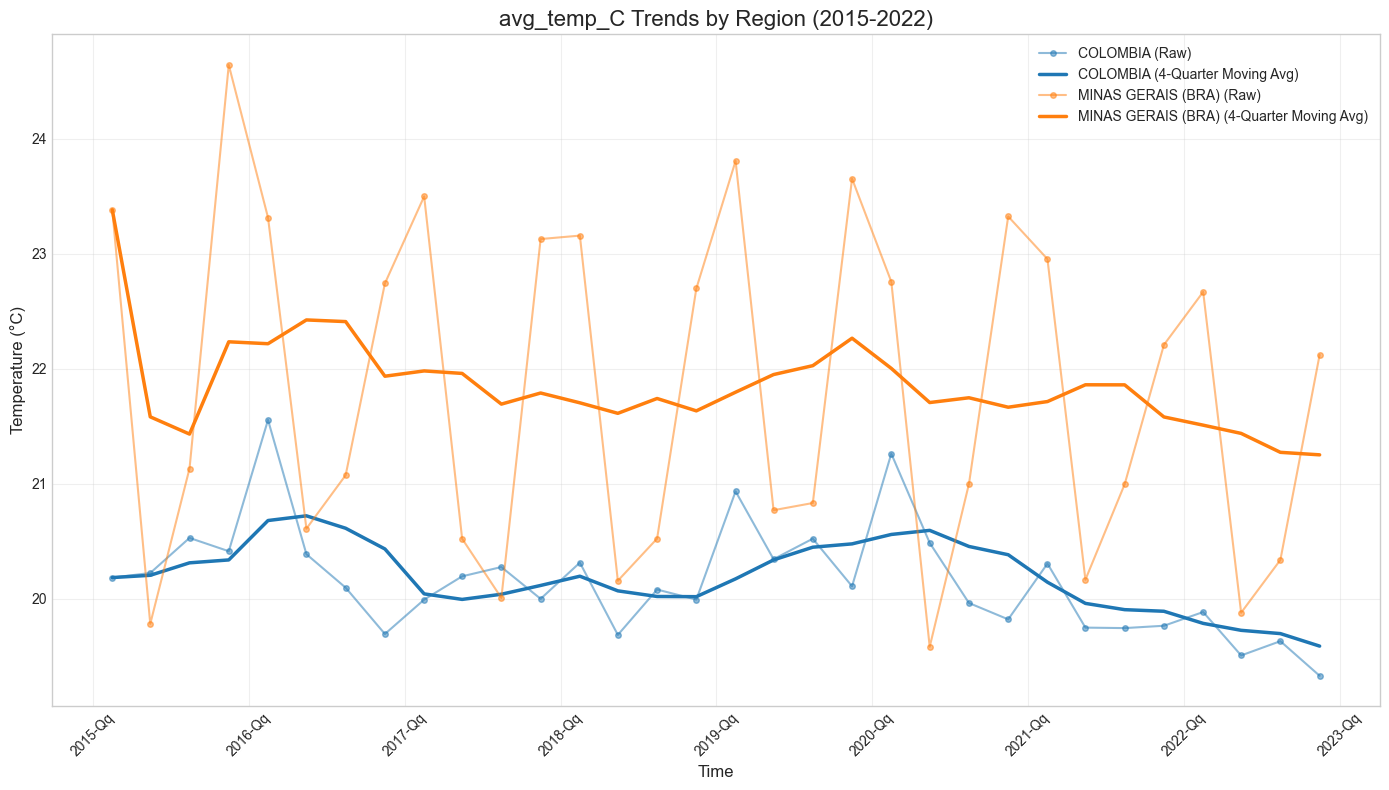

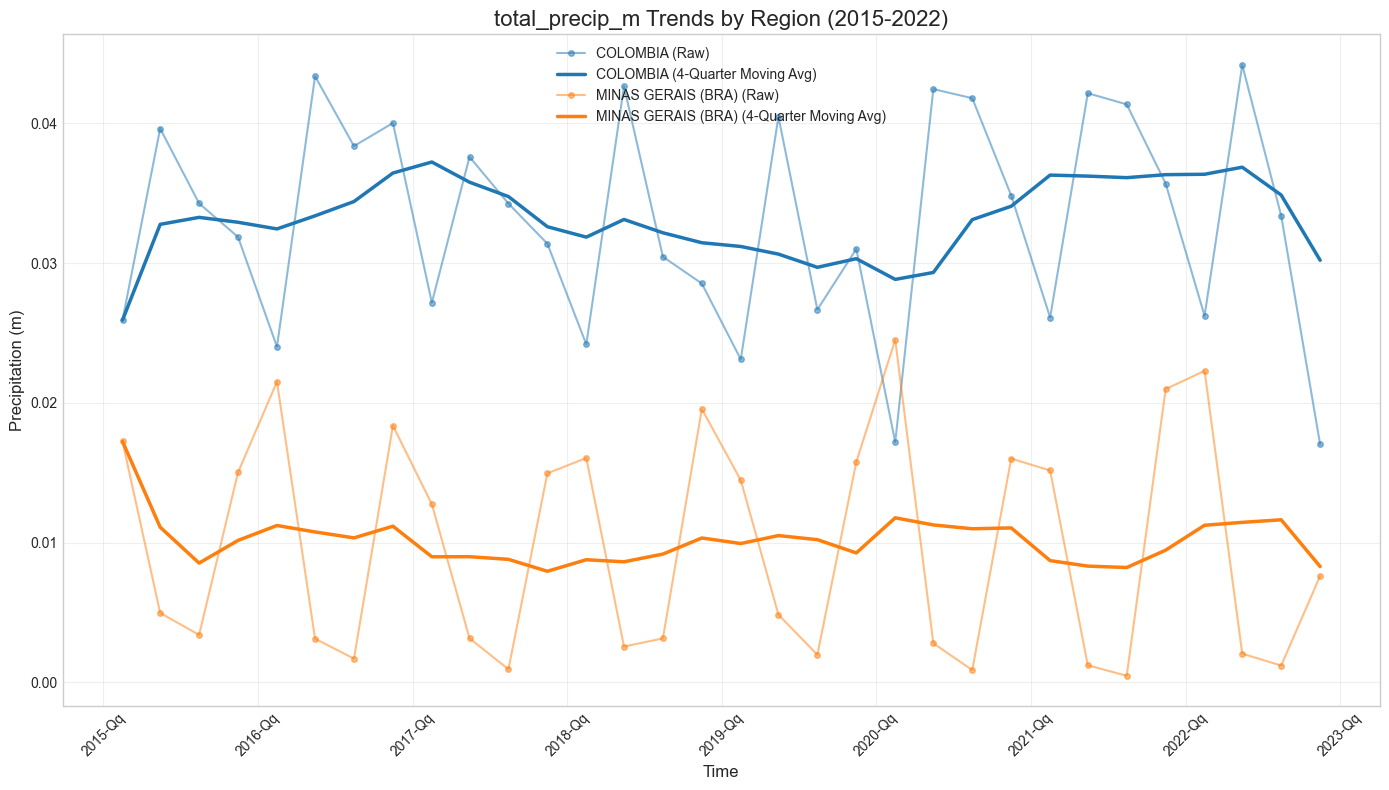

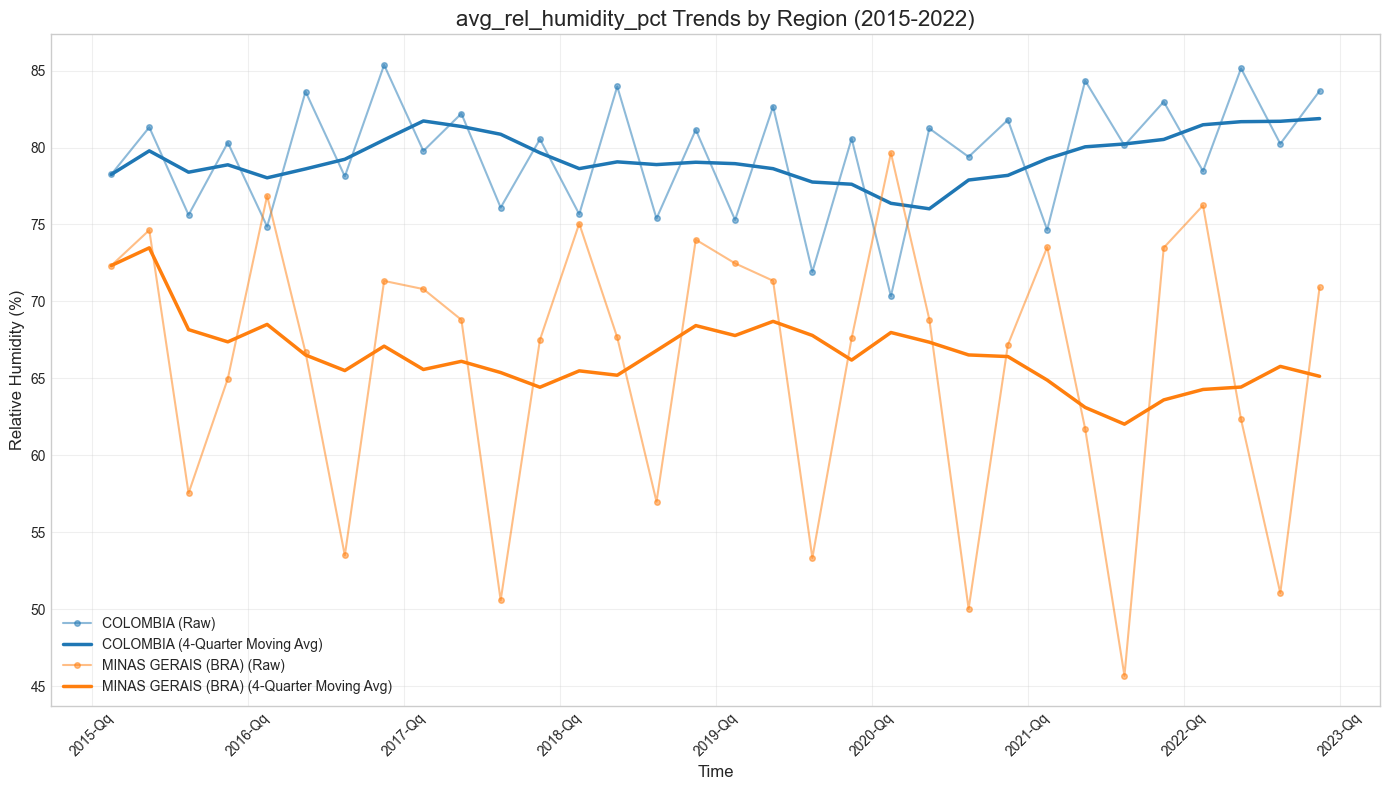

In [78]:
def plot_climate_trends(climate_df, variable, title=None, rolling_window=None):
    """
    Plot climate variable trends with optional moving average.
    
    Parameters:
    -----------
    climate_df : pd.DataFrame
        Processed climate data
    variable : str
        Variable to plot (column name)
    title : str, optional
        Plot title
    rolling_window : int, optional
        Window size for rolling average (quarters)
    """
    if climate_df is None or len(climate_df) == 0:
        print("No data available for plotting")
        return
    
    # Get the year range for the title
    years = sorted(climate_df['Year'].unique())
    year_range = f"{years[0]}-{years[-1]}"
    
    if title is None:
        title = f"{variable} Trends by Region ({year_range})"
    
    # Prepare plot data
    regions = climate_df['Region'].unique()
    
    # Create figure
    plt.figure(figsize=(14, 8))
    
    # Define colors for regions
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, region in enumerate(regions):
        region_data = climate_df[climate_df['Region'] == region].copy()
        region_data = region_data.sort_values(['Year', 'Quarter'])
        
        # Create a date index for proper time series plotting
        region_data['YearQuarter'] = region_data.apply(
            lambda x: pd.Timestamp(year=int(x['Year']), month=(int(x['Quarter'])-1)*3+2, day=15), 
            axis=1
        )
        region_data = region_data.sort_values('YearQuarter')
        
        # Plot the raw data with smaller markers
        color = colors[i % len(colors)]
        plt.plot(region_data['YearQuarter'], region_data[variable], 
                 marker='o', markersize=4, alpha=0.5, 
                 color=color, label=f"{region} (Raw)")
        
        # Plot rolling average if requested
        if rolling_window:
            region_data = region_data.set_index('YearQuarter')
            rolling_avg = region_data[variable].rolling(window=rolling_window, min_periods=1).mean()
            plt.plot(rolling_avg.index, rolling_avg, 
                     linewidth=2.5, color=color, 
                     label=f"{region} ({rolling_window}-Quarter Moving Avg)")
    
    # Format the plot
    plt.title(title, fontsize=16)
    plt.xlabel("Time", fontsize=12)
    
    # Set appropriate y-axis label based on variable
    if variable == 'avg_temp_C':
        plt.ylabel("Temperature (°C)", fontsize=12)
    elif variable == 'total_precip_m':
        plt.ylabel("Precipitation (m)", fontsize=12)
    elif variable == 'avg_rel_humidity_pct':
        plt.ylabel("Relative Humidity (%)", fontsize=12)
    else:
        plt.ylabel(variable, fontsize=12)
        
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Format x-axis as dates
    from matplotlib.dates import DateFormatter
    date_format = DateFormatter('%Y-Q%q')
    plt.gca().xaxis.set_major_formatter(date_format)
    
    # Add legend
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()

# Check if we have data to plot
if climate_data is not None:
    # Plot temperature trends with 4-quarter moving average
    plot_climate_trends(
        climate_data, 
        'avg_temp_C', 
        rolling_window=4
    )
    
    # Plot precipitation trends with 4-quarter moving average
    plot_climate_trends(
        climate_data, 
        'total_precip_m', 
        rolling_window=4
    )
    
    # Plot humidity trends with 4-quarter moving average, if available
    if 'avg_rel_humidity_pct' in climate_data.columns:
        plot_climate_trends(
            climate_data, 
            'avg_rel_humidity_pct', 
            rolling_window=4
        )

## 6. Analyze Seasonal Patterns

Next, we'll analyze the seasonal patterns in the coffee growing regions. This will help us understand how climate variables change throughout the year, which is important for coffee growing cycles.

For coffee production, the timing of wet and dry seasons is critical. Coffee trees typically flower during dry periods followed by rain, and the ripening process depends on seasonal temperature patterns.

## 7. Calculate Climate Anomalies

Climate anomalies measure how current conditions deviate from a baseline or reference period. This helps identify unusual climate patterns that might affect coffee production.

We'll use the first three years of data (2015-2017) as our baseline and calculate anomalies for temperature and precipitation.

## 8. Perform Statistical Analysis

Finally, we'll conduct statistical analysis to identify significant trends in the climate data. This helps determine if the observed changes are statistically significant or just normal variation.

We'll use linear regression to quantify trends and p-values to determine statistical significance.

Using 2015-2017 as baseline for anomaly calculations


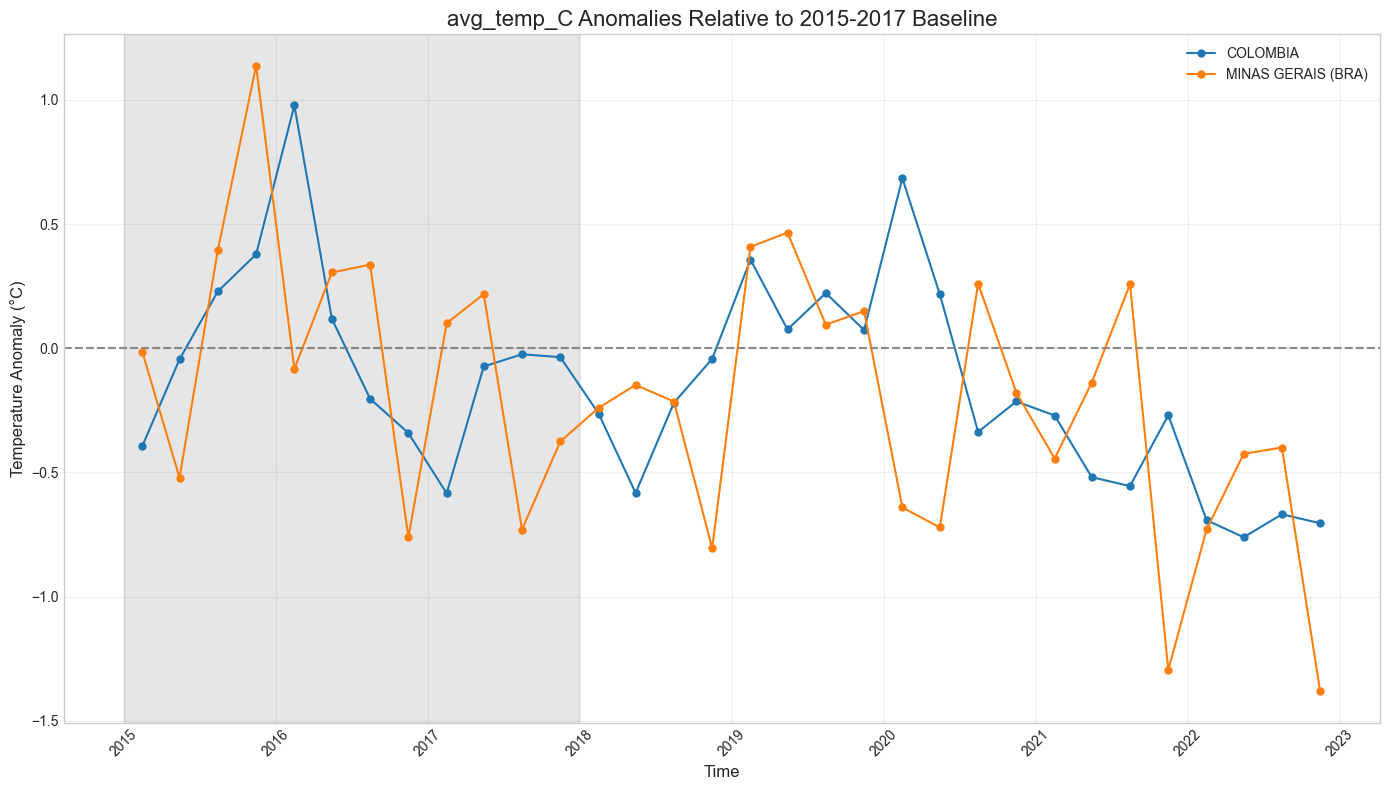

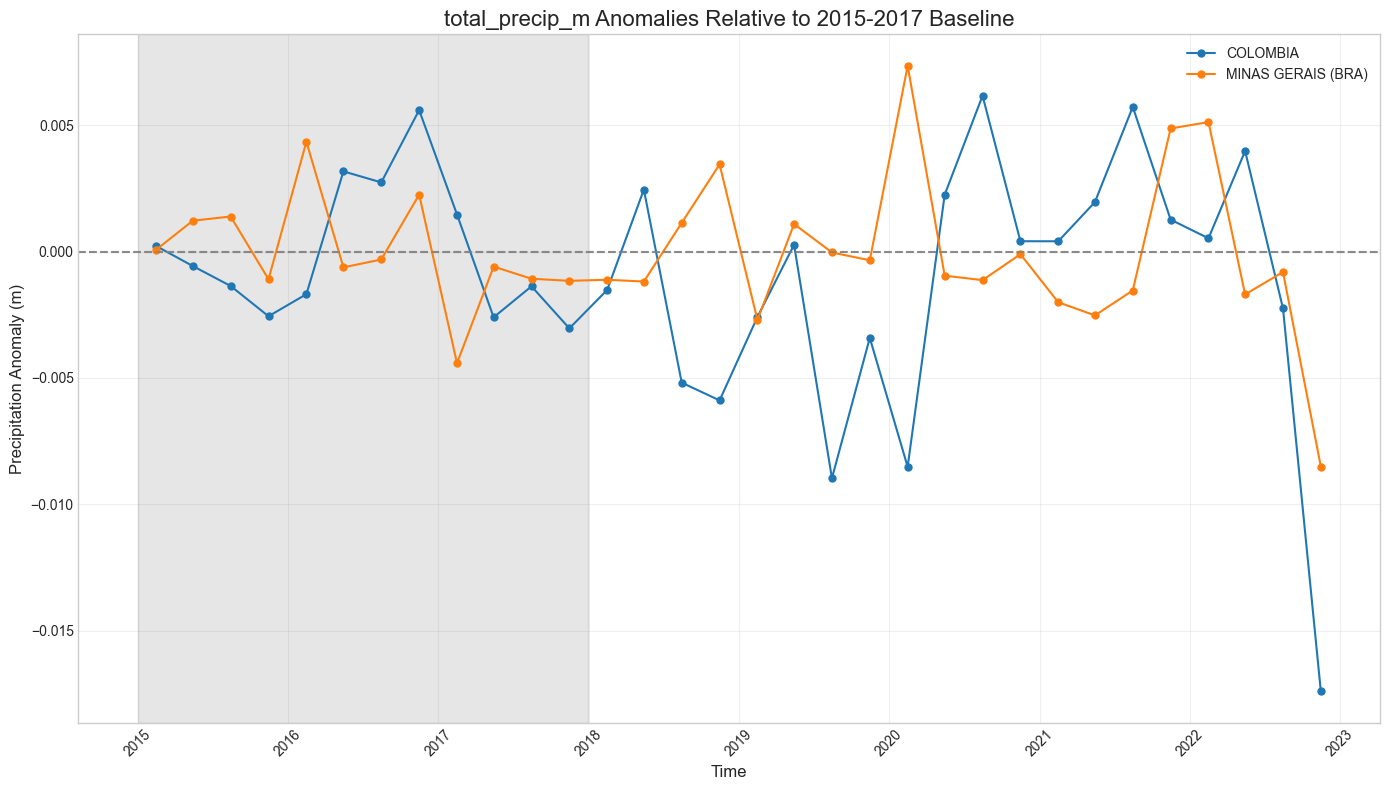

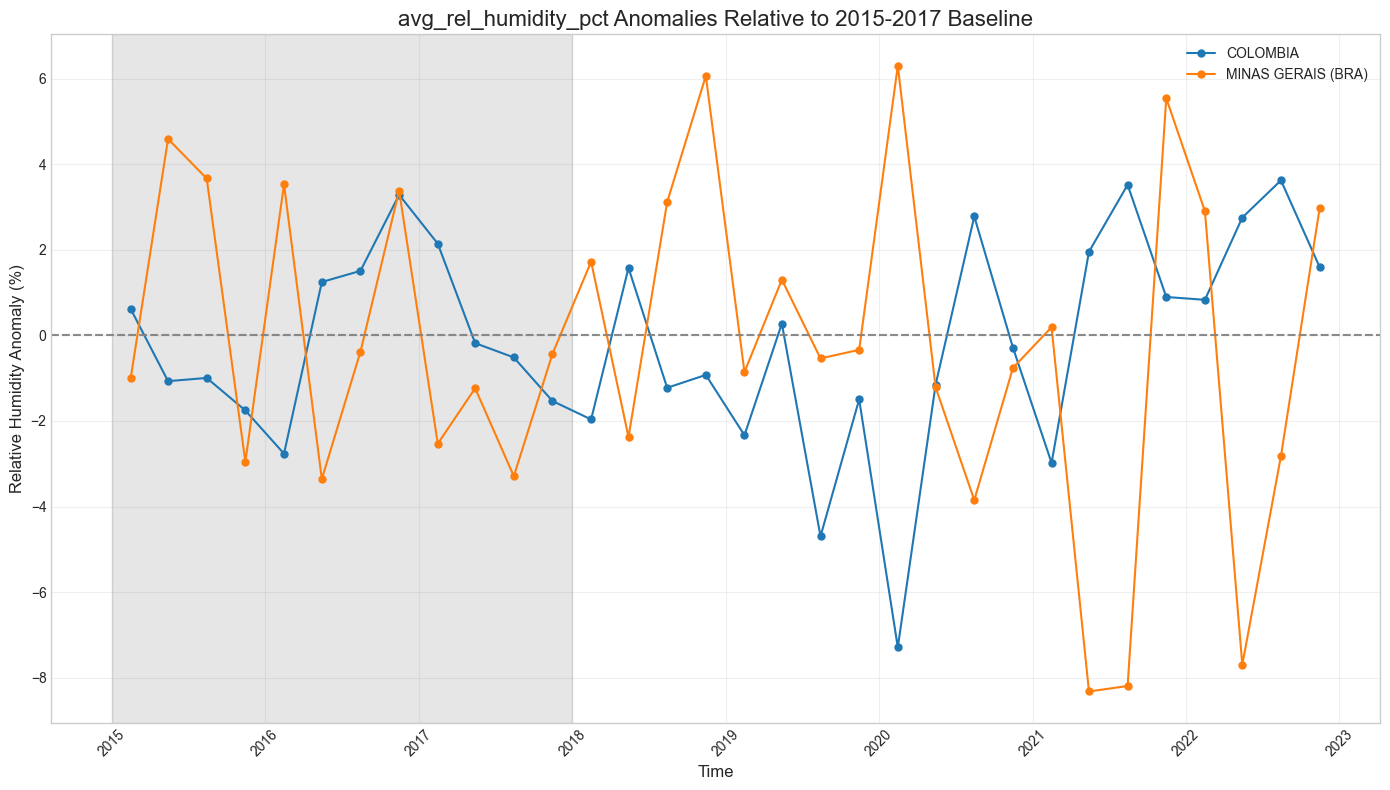

In [79]:
def plot_climate_anomalies(climate_df, variable, baseline_years=None, title=None):
    """
    Plot climate anomalies against a baseline period.
    
    Parameters:
    -----------
    climate_df : pd.DataFrame
        Processed climate data
    variable : str
        Variable to plot (column name)
    baseline_years : list, optional
        List of years to use as baseline. If None, uses first 3 years.
    title : str, optional
        Plot title
    """
    if climate_df is None or len(climate_df) == 0:
        print("No data available for plotting")
        return
    
    # Set appropriate y-axis label
    if variable == 'avg_temp_C':
        y_label = "Temperature Anomaly (°C)"
    elif variable == 'total_precip_m':
        y_label = "Precipitation Anomaly (m)"
    elif variable == 'avg_rel_humidity_pct':
        y_label = "Relative Humidity Anomaly (%)"
    else:
        y_label = f"{variable} Anomaly"
    
    # Get all years in dataset
    all_years = sorted(climate_df['Year'].unique())
    
    # Set default baseline if not provided
    if baseline_years is None:
        min_year = all_years[0]
        baseline_years = list(range(min_year, min_year + 3))
    
    if title is None:
        title = f"{variable} Anomalies Relative to {baseline_years[0]}-{baseline_years[-1]} Baseline"
    
    # Make sure baseline years exist in the data
    valid_baseline_years = [y for y in baseline_years if y in all_years]
    if len(valid_baseline_years) < 2:
        print(f"Not enough valid baseline years. Using first 2 years as baseline.")
        valid_baseline_years = all_years[:2]
    
    # Prepare plot data
    regions = climate_df['Region'].unique()
    
    # Create figure
    plt.figure(figsize=(14, 8))
    
    # Define colors for regions
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, region in enumerate(regions):
        region_data = climate_df[climate_df['Region'] == region].copy()
        
        # Calculate baseline values by quarter
        baseline_data = region_data[region_data['Year'].isin(valid_baseline_years)]
        if len(baseline_data) == 0:
            print(f"No baseline data for {region}. Skipping.")
            continue
            
        baseline_means = baseline_data.groupby('Quarter')[variable].mean()
        
        # Create anomalies by subtracting baseline from actual values
        anomalies = []
        dates = []
        
        for _, row in region_data.iterrows():
            year, quarter = row['Year'], row['Quarter']
            value = row[variable]
            
            # Skip if this quarter doesn't have a baseline value
            if quarter not in baseline_means.index:
                continue
                
            baseline = baseline_means[quarter]
            anomaly = value - baseline
            
            # Create timestamp for plotting
            date = pd.Timestamp(year=int(year), month=(int(quarter)-1)*3+2, day=15)
            
            anomalies.append(anomaly)
            dates.append(date)
        
        # Create anomaly data
        anomaly_data = pd.DataFrame({
            'Date': dates,
            'Anomaly': anomalies
        })
        anomaly_data = anomaly_data.sort_values('Date')
        
        # Plot the anomalies
        color = colors[i % len(colors)]
        plt.plot(anomaly_data['Date'], anomaly_data['Anomaly'], 
                 marker='o', markersize=5, color=color, label=region)
        
        # Add a horizontal line at zero
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
        
        # Add shading for the baseline period
        baseline_start = pd.Timestamp(year=valid_baseline_years[0], month=1, day=1)
        baseline_end = pd.Timestamp(year=valid_baseline_years[-1], month=12, day=31)
        plt.axvspan(baseline_start, baseline_end, color='gray', alpha=0.1)
    
    # Format the plot
    plt.title(title, fontsize=16)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Add legend
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()

# Check if we have enough years of data to plot anomalies
if climate_data is not None:
    # Get all years in data
    available_years = sorted(climate_data['Year'].unique())
    
    # Use first 3 years as baseline if we have 5+ years of data
    if len(available_years) >= 5:
        baseline = available_years[:3]
        print(f"Using {baseline[0]}-{baseline[-1]} as baseline for anomaly calculations")
        
        # Calculate temperature anomalies
        plot_climate_anomalies(
            climate_data, 
            'avg_temp_C', 
            baseline_years=baseline
        )
        
        # Calculate precipitation anomalies
        plot_climate_anomalies(
            climate_data, 
            'total_precip_m', 
            baseline_years=baseline
        )
        
        # Calculate humidity anomalies if available
        if 'avg_rel_humidity_pct' in climate_data.columns:
            plot_climate_anomalies(
                climate_data, 
                'avg_rel_humidity_pct', 
                baseline_years=baseline
            )
    else:
        print("Insufficient data for anomaly plots. Need at least 5 years of data.")

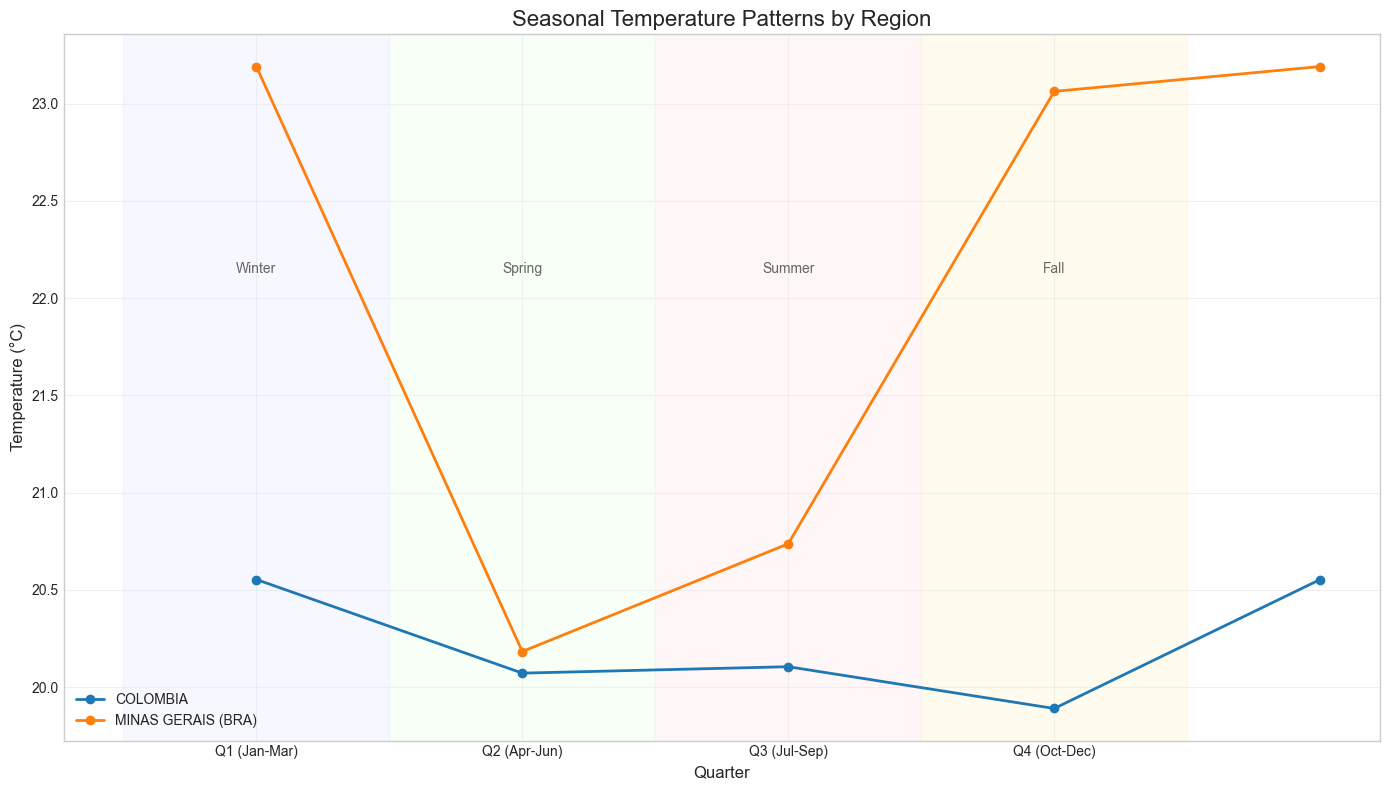

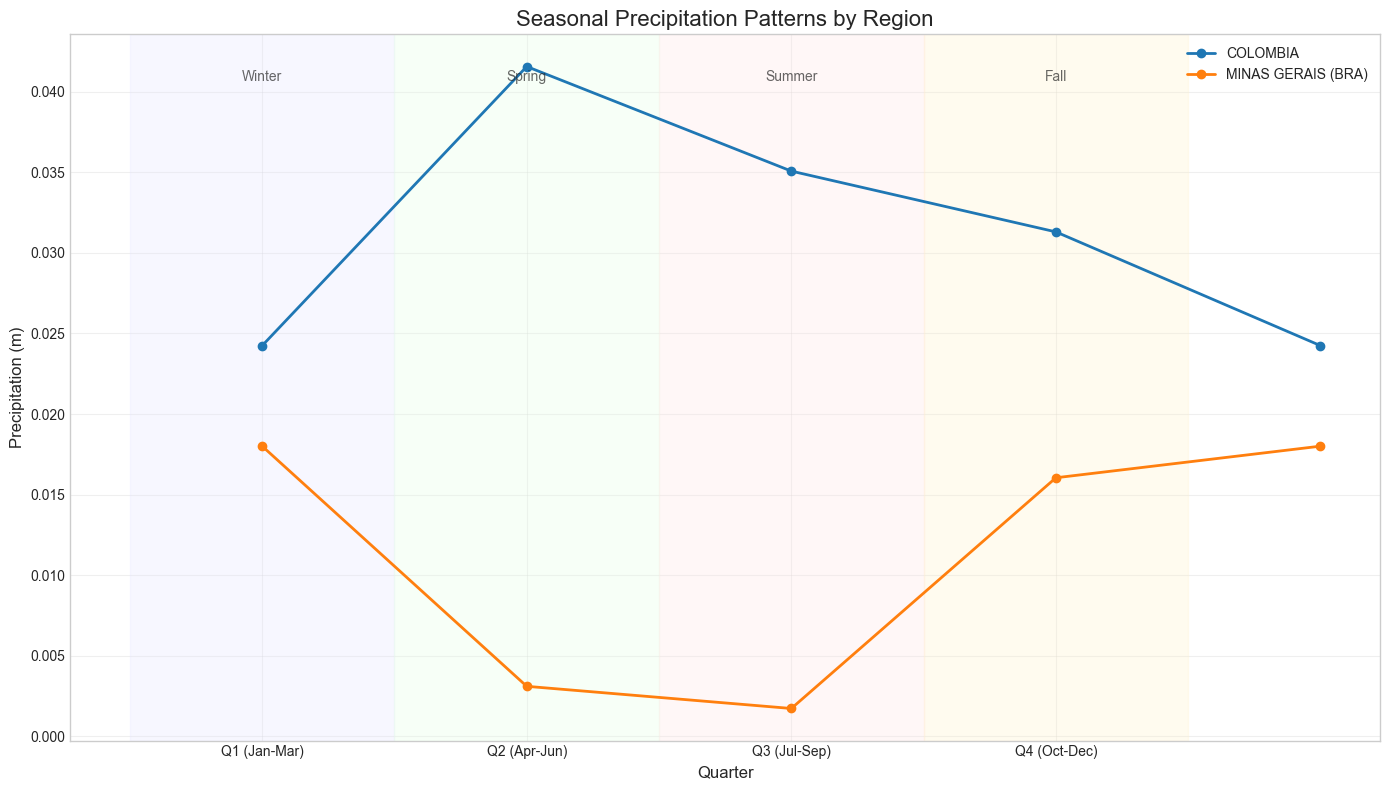

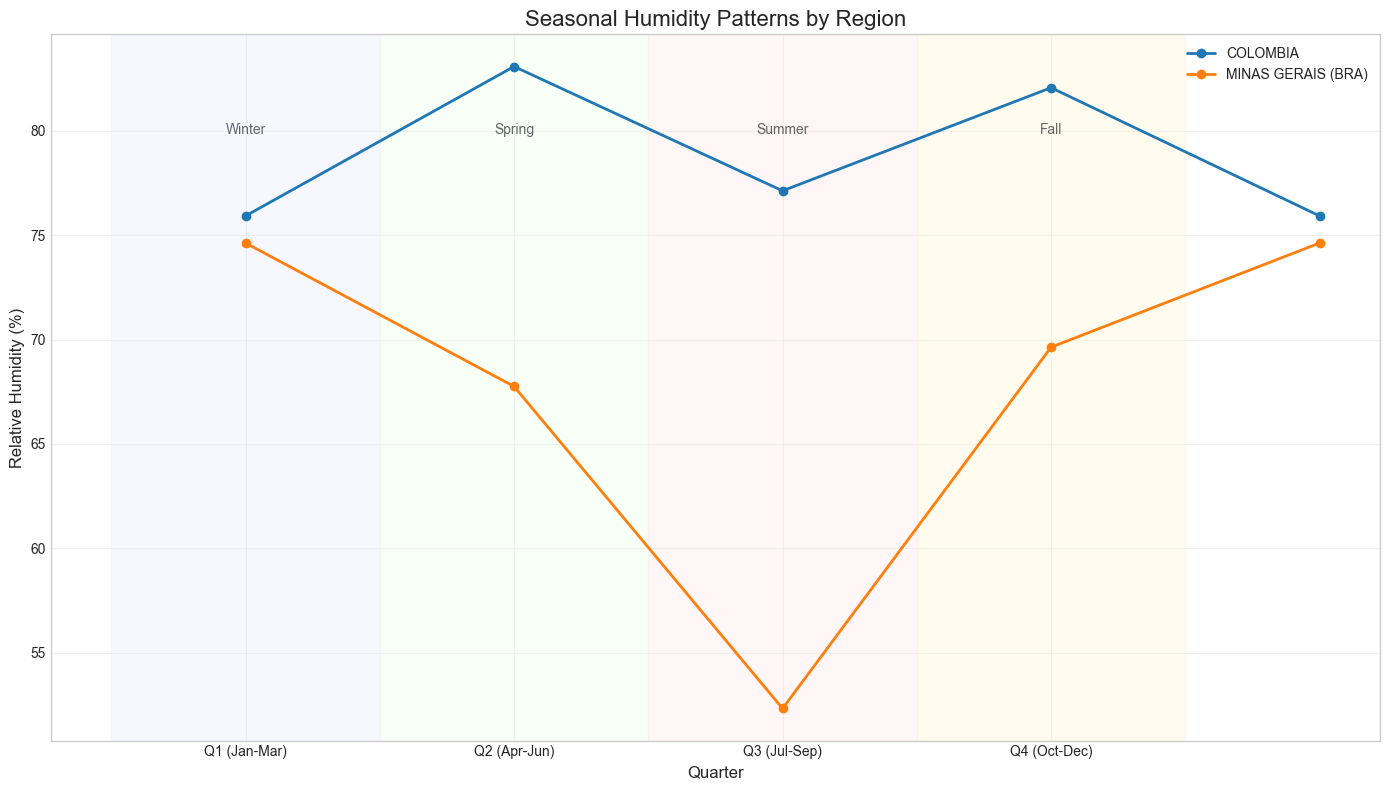

In [80]:
def plot_seasonal_patterns(climate_df, variable, title=None):
    """
    Plot seasonal patterns for each region.
    
    Parameters:
    -----------
    climate_df : pd.DataFrame
        Processed climate data
    variable : str
        Variable to plot (column name)
    title : str, optional
        Plot title
    """
    if climate_df is None or len(climate_df) == 0:
        print("No data available for plotting")
        return
    
    # Set appropriate title and y-axis label
    if variable == 'avg_temp_C':
        y_label = "Temperature (°C)"
        if title is None:
            title = f"Seasonal Temperature Patterns by Region"
    elif variable == 'total_precip_m':
        y_label = "Precipitation (m)"
        if title is None:
            title = f"Seasonal Precipitation Patterns by Region"
    elif variable == 'avg_rel_humidity_pct':
        y_label = "Relative Humidity (%)"
        if title is None:
            title = f"Seasonal Humidity Patterns by Region"
    else:
        y_label = variable
        if title is None:
            title = f"Seasonal {variable} Patterns by Region"
    
    # Prepare plot data
    regions = climate_df['Region'].unique()
    
    # Create figure
    plt.figure(figsize=(14, 8))
    
    # Calculate quarterly averages for each region
    for region in regions:
        region_data = climate_df[climate_df['Region'] == region]
        
        # Group by quarter and calculate mean
        quarterly_means = region_data.groupby('Quarter')[variable].mean()
        quarters = quarterly_means.index
        values = quarterly_means.values
        
        # Extend to show wrap-around
        extended_quarters = list(quarters) + [5]
        extended_values = list(values) + [values[0]]
        
        # Plot the seasonal pattern
        plt.plot(extended_quarters, extended_values, marker='o', linewidth=2, label=region)
    
    # Format the plot
    plt.title(title, fontsize=16)
    plt.xlabel("Quarter", fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks([1, 2, 3, 4], ['Q1 (Jan-Mar)', 'Q2 (Apr-Jun)', 'Q3 (Jul-Sep)', 'Q4 (Oct-Dec)'])
    
    # Add shading for seasons (Northern Hemisphere)
    season_colors = [(0.9, 0.9, 1.0), (0.9, 1.0, 0.9), (1.0, 0.9, 0.9), (1.0, 0.95, 0.8)]
    season_names = ['Winter', 'Spring', 'Summer', 'Fall']
    
    # Add coffee phenology markers for Arabica coffee
    coffee_phases = [
        (1, "Flower bud development"),
        (2, "Flowering & fruit set"),
        (3, "Bean development"),
        (4, "Ripening & harvest")
    ]
    
    for i, (color, name) in enumerate(zip(season_colors, season_names)):
        plt.axvspan(i+0.5, i+1.5, color=color, alpha=0.3)
        plt.text(i+1, plt.ylim()[1]*0.95, name, 
                 horizontalalignment='center', 
                 verticalalignment='top',
                 fontsize=10, alpha=0.7)
    
    # Add legend
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()

# Plot seasonal patterns
if climate_data is not None:
    # Plot temperature seasonal patterns
    plot_seasonal_patterns(
        climate_data, 
        'avg_temp_C'
    )
    
    # Plot precipitation seasonal patterns
    plot_seasonal_patterns(
        climate_data, 
        'total_precip_m'
    )
    
    # Plot humidity seasonal patterns if available
    if 'avg_rel_humidity_pct' in climate_data.columns:
        plot_seasonal_patterns(
            climate_data, 
            'avg_rel_humidity_pct'
        )

## 9. Additional Information: Processing Extended Data

The extended dataset (2015-2022) was created using a separate script `run_extended_data.py`, which:

1. Processes data from the 2015-2022 NetCDF files (which are actually ZIP archives)
2. Extracts and processes the GRIB files inside them
3. Creates an extended CSV file with 8 years of data (2015-2022)

To regenerate this extended dataset, you can run:

```bash
./run_extended.sh
```

This will process the 2015-2022 data files and create a new `coffee_climate_extended.csv` file with the full 8-year dataset. This extended dataset provides much better coverage for trend analysis and climate pattern detection.